## $$\textrm{Linear Model Selection and Regularization}$$




## 1. 기본 설정

In [ ]:
!pip install ISLP
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 818.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.5/890.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 3.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=dc5dff09824ffe640bb907cc54b114b9296807a9f79ce7dd63a560c6fe4e81e2
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise , sklearn_selected , sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path

## 2. 단계선택법

In [ ]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()
Hitters = Hitters.dropna(); Hitters.shape

(263, 20)

- Cp 계산법 (변형이 있음에 유의) 및 함수 설정

In [ ]:
def nCp(sigma2, estimator, X, Y):
  n, p = X.shape
  Yhat = estimator.predict(X)
  RSS = np.sum((Y - Yhat)**2)
  return -(RSS + 2 * p * sigma2) / n

design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

neg_Cp = partial(nCp, sigma2)
print(neg_Cp)

functools.partial(<function nCp at 0x794a7b895f30>, 99591.35617968219)


- 단계적 선택 방법을 적용 (사용하는 측도는 일반적으로 P.VALUE)

In [ ]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

- 단계적 선택을 하되 Cp를 이용함

In [ ]:
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(Hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

- 단계적 선택 과정에서 모든 예측치를 행렬로 모아 놓음



In [ ]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS, strategy)
full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

- 위에서 저장한 예측치로 (훈련 데이터의) 예측오차를 계산해서 그림

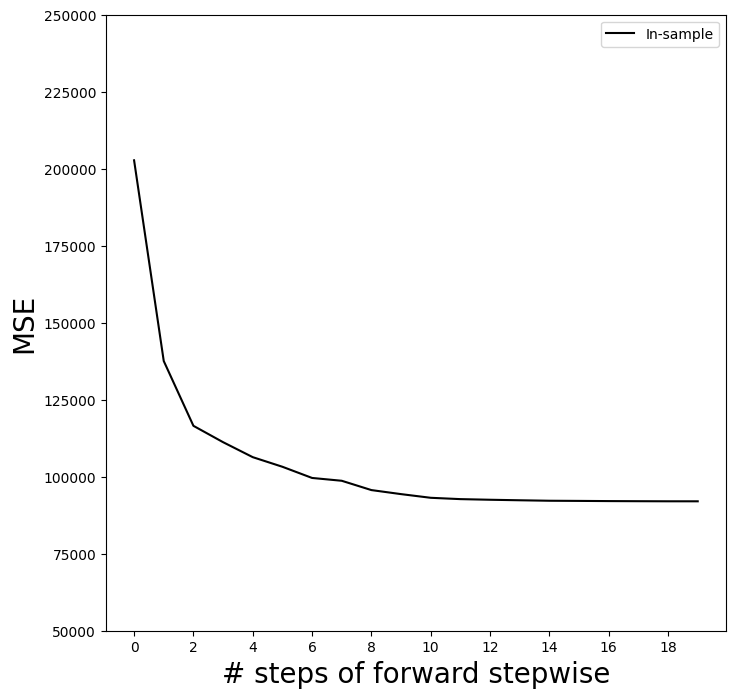

In [ ]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]
ax.plot(np.arange(n_steps), insample_mse,
        'k', # color black
        label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# steps of forward stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000]);

##3. 교차검증오차의 활용

- 10 folder CV를 통해서 예측된 값들을 모아 놓음 (훈련과 검증을 구분했음에 유의)

In [ ]:
K=10
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
print(Yhat_cv.shape)

(263, 20)


- 위의 결과에 대한 훈련 오차와 교차 검증 오차를 같이 보여줌

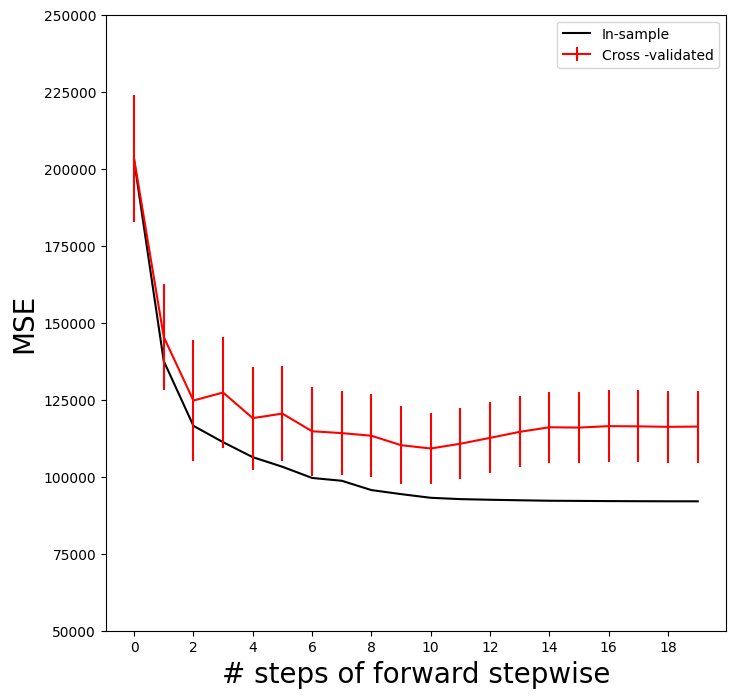

In [ ]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
  errors = (Yhat_cv[test_idx] - Y[test_idx ,None])**2
  cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

ax.errorbar(np.arange(n_steps),
cv_mse.mean(1),
cv_mse.std(1) / np.sqrt(K), # 교차검증오차의 표준오차
label='Cross -validated', c='r')
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

- 훈련 예측 오차와 Validation set을 이용한 평가 예측 오차를 덧붙임

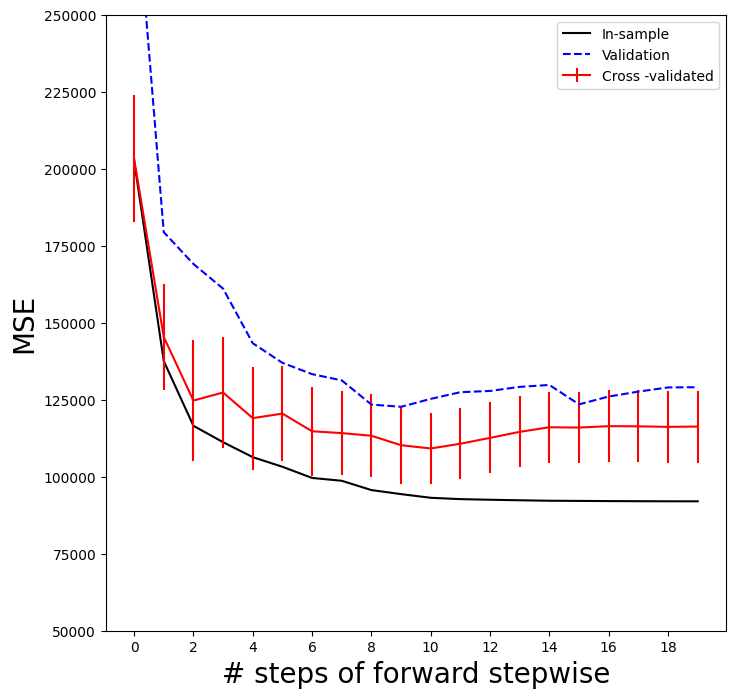

In [ ]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2,
                             random_state=0)
for train_idx, test_idx in validation.split(Y):
  full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
  Yhat_val = full_path.predict(Hitters.iloc[test_idx])
  errors = (Yhat_val - Y[test_idx ,None])**2
  validation_mse = errors.mean(0)

ax.plot(np.arange(n_steps), validation_mse ,
 'b--', # color blue, broken line
 label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

## 3. 축소 알고리즘

- LASSO type

In [ ]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [ ]:
print(path[16])

{'B': array([  -1.20831273,    4.64432264,    0.        ,    0.        ,
          0.        ,    4.59805059,  -11.6699466 ,    0.        ,
          0.        ,    0.        ,    0.58710796,    0.54935239,
         -0.45671348,    0.        , -126.39657952,    0.26498974,
          0.        ,    0.        ,    0.        ]), 'B0': 131.78366110767536, 'lambda_0': 0.00042410060938560226, 'M': 0.5574849768321161, 'Time_exceeded': False}


- Ridge 회귀분석

In [ ]:
Xs = X - X.mean(0)[None ,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None ,:]

lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)[1]

In [ ]:
print(soln_array.shape)
soln_array[3]

(19, 100)


array([ 8.51171628e-04,  1.07404833e-03,  1.35528184e-03,  1.71015031e-03,
        2.15793086e-03,  2.72294564e-03,  3.43588130e-03,  4.33545289e-03,
        5.47050203e-03,  6.90264191e-03,  8.70959098e-03,  1.09893734e-02,
        1.38656092e-02,  1.74941743e-02,  2.20715784e-02,  2.78454973e-02,
        3.51279994e-02,  4.43121333e-02,  5.58926995e-02,  7.04922055e-02,
        8.88932145e-02,  1.12078525e-01,  1.41280867e-01,  1.78044021e-01,
        2.24297451e-01,  2.82446589e-01,  3.55480677e-01,  4.47099466e-01,
        5.61858650e-01,  7.05331420e-01,  8.84279316e-01,  1.10681898e+00,
        1.38256186e+00,  1.72269067e+00,  2.13992025e+00,  2.64827250e+00,
        3.26258076e+00,  3.99763623e+00,  4.86691125e+00,  5.88085549e+00,
        7.04487111e+00,  8.35722423e+00,  9.80730468e+00,  1.13747359e+01,
        1.30297833e+01,  1.47352712e+01,  1.64498414e+01,  1.81319975e+01,
        1.97441485e+01,  2.12558809e+01,  2.26459368e+01,  2.39027306e+01,
        2.50235529e+01,  

 - 벌점함수의 초매개변수에 의해서 추정된 회귀계수의 변화를 추적

In [ ]:
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


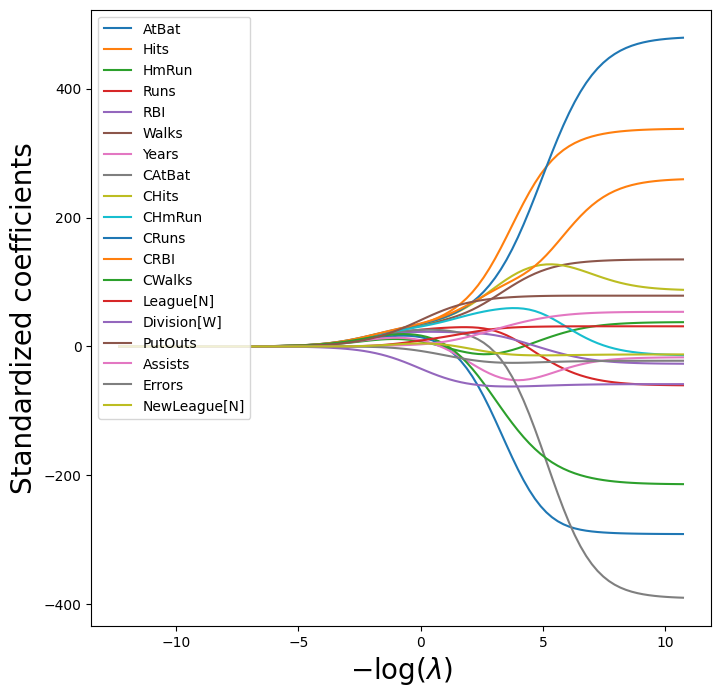

In [ ]:
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

- 중간에 하나를 살펴봄

In [ ]:
beta_hat = soln_path.loc[soln_path.index[50]]
lambdas[50], beta_hat, np.linalg.norm(beta_hat)

(1.97711243041609,
 AtBat           16.736510
 Hits            27.154006
 HmRun           11.071130
 Runs            22.645937
 RBI             21.214362
 Walks           26.593380
 Years           13.134470
 CAtBat          23.909104
 CHits           28.375692
 CHmRun          26.148683
 CRuns           29.012704
 CRBI            29.499455
 CWalks          19.180750
 League[N]        5.677305
 Division[W]    -23.833230
 PutOuts         29.312404
 Assists          2.004304
 Errors          -3.653105
 NewLeague[N]     3.865199
 Name: -0.6816374117753777, dtype: float64,
 92.81615742902515)


- 설정된 초매개변수에 따라 추정된 회귀계수의 크기를 계산해 봄

In [ ]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True , with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X, Y)
np.linalg.norm(ridge.coef_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


160.42371017725904

- 훈련과 검증 데이터를 나누어 검증 오차를 계산함

In [ ]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
ridge.alpha = 1e1
results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation)
print(-results['test_score'])

[132790.68707108]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.737e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


- 가장 좋은 초매개변수의 값을 validation set을 이용해서 찾음

In [ ]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe ,
param_grid, cv=validation, scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
print(grid.best_estimator_)

In [ ]:
print(grid.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])


- 교차 검증 오차를 이용한 선택 및 교차 검증 오차의 확인

In [ ]:
grid = skm.GridSearchCV(pipe,
param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']

In [ ]:
print(grid.best_estimator_)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])


- 교차 검증 오차의 도표화

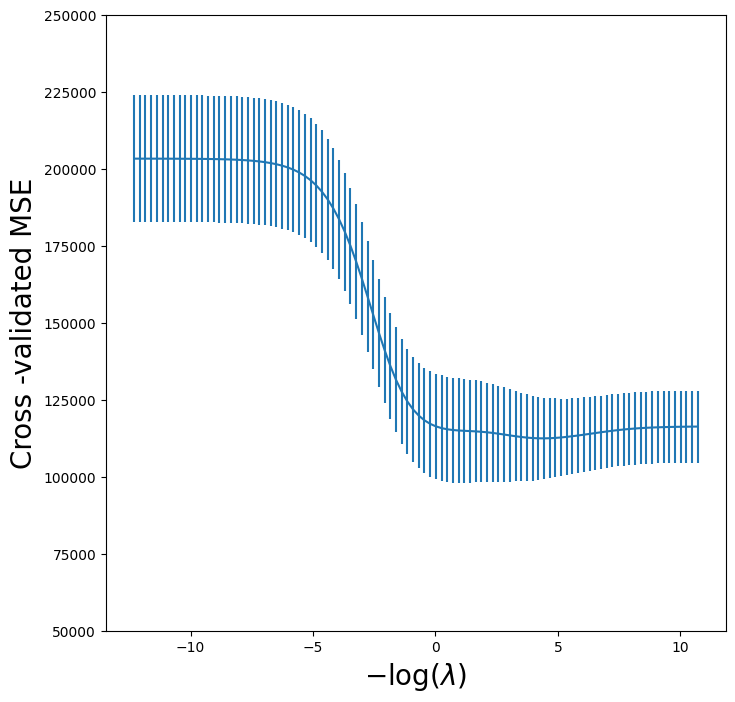

In [ ]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
-grid.cv_results_['mean_test_score'],
yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20);

- 패스 알고리즘에 의해서 더 바른 초매개변수 튜닝이 가능함

In [ ]:
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold)
grid_r2.fit(X, Y)

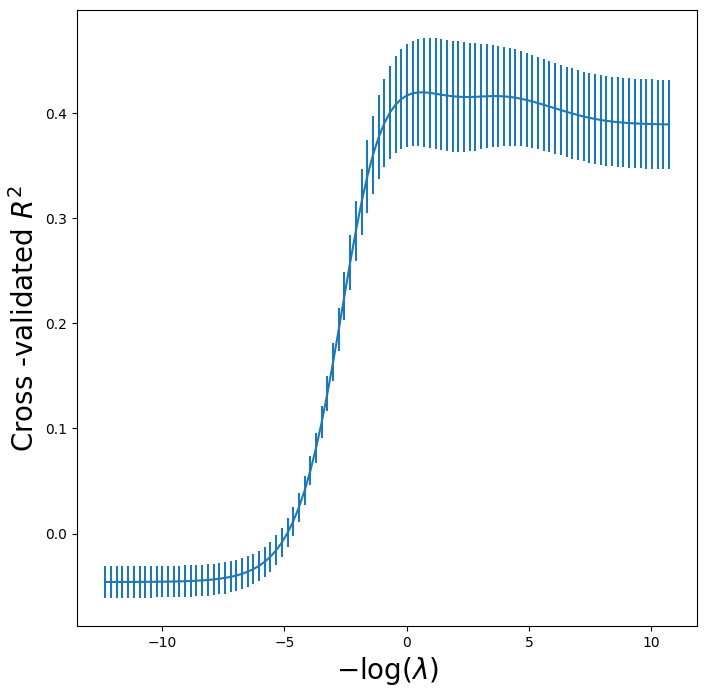

In [ ]:
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
grid_r2.cv_results_['mean_test_score'],
yerr = grid_r2.cv_results_['std_test_score'] / np.sqrt(K)
)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated $R^2$', fontsize=20);

- 교차 검증 오차를 통해서 초매개변수를 선택함

In [ ]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

(112362.26398006322,
 array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
           3.64888723,  108.90953869,  -50.81896152, -105.15731984,
         122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
        -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
          40.07350744,  -25.02151514,  -13.68429544]))

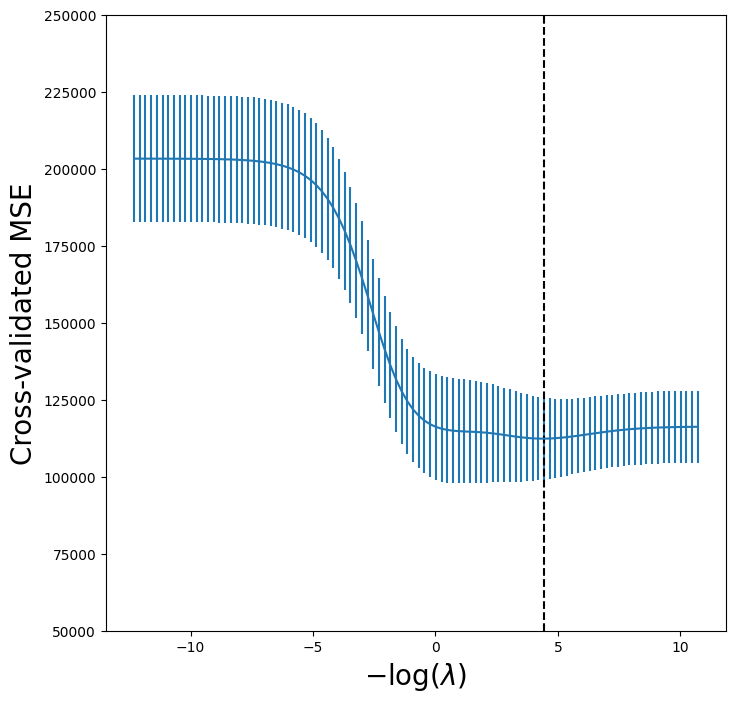

In [ ]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
tuned_ridge.mse_path_.mean(1),
yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

np.min(tuned_ridge.mse_path_.mean(1)), tuned_ridge.coef_

- 교차 검증 오차 방법의 검증 데이터 셋을 이용한 방법과 비교함 (일반적으로 데이터가 적은 경우 교차 검증 오차를 사용함) \

In [ ]:
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
inner_cv = skm.KFold(n_splits=5, shuffle=True,random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)]);
results = skm.cross_validate(pipeCV, X, Y, cv=outer_valid, scoring='neg_mean_squared_error')

In [ ]:
-results['test_score']

array([132393.84003227])

- LASSO 회귀분석

In [ ]:
import sklearn.preprocessing as skp
scaler = skp.StandardScaler()

lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

2.9351237625863815

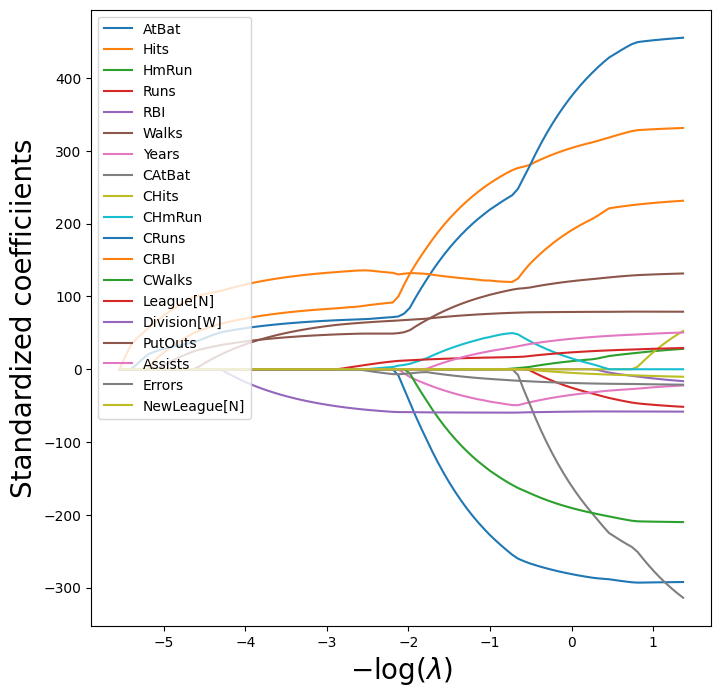

In [ ]:
lambdas, soln_array = skl.Lasso.path(Xs, Y, l1_ratio=1, n_alphas =100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
path_fig , ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [ ]:
np.min(tuned_lasso.mse_path_.mean(1))

111643.39348122066

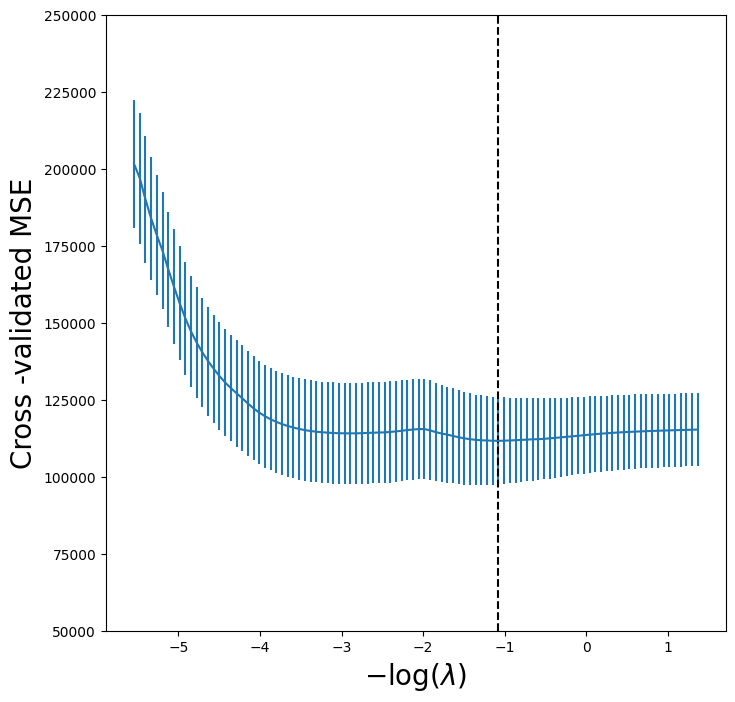

In [ ]:
lassoCV_fig , ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim ([50000 ,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross -validated MSE', fontsize=20);

- PCA 회귀분석

  - 주성분 분석을 통해서 얻게 된 주성분을 이용해서 회귀분석을 시행
  - 여기에서 주성분은 입력 변수 차원에서만 얻는 것임에 주의


In [ ]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca), ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_  # PC 2개로 회귀분석을 진행

array([0.09846131, 0.4758765 ])

In [ ]:
pipe = Pipeline([('scaler', scaler),
('pca', pca),
('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_ # 표준화 이후 회귀분석을 진행

array([106.36859204,  21.60350456])

In [ ]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

- 교차 검증 오차를 통해서 어느 정도의 주성분 개수를 선택해야 하는지를 결정하려고 함

- 주성분 개수가 3개 이상으로 내려가면서 큰 변화가 없을 알 수 있음

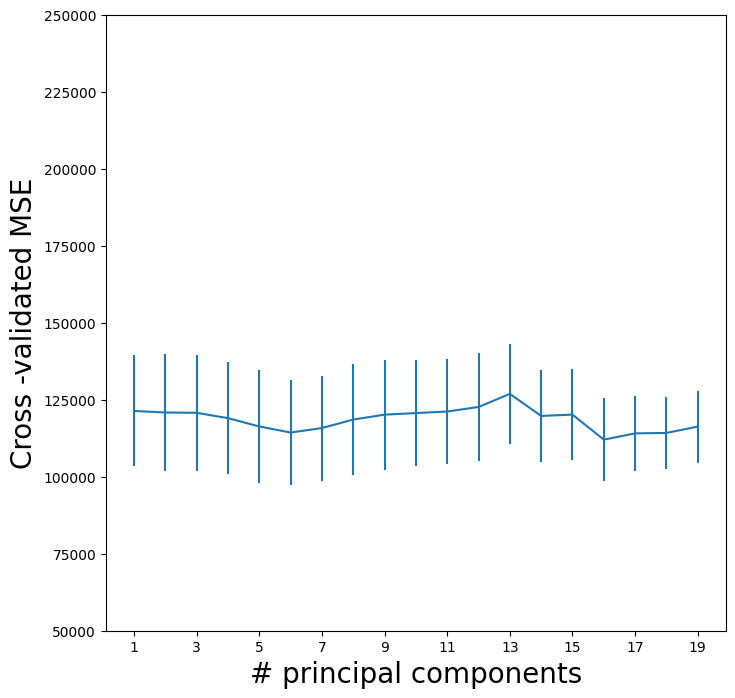

In [ ]:
pcr_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2])
ax.set_ylim ([50000 ,250000]);

In [ ]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

- PLS (Partial Least Squares Regression)

   - $ X = T P^{\top} + E, \ Y= U Q^{\top} + F$ 구조를 가정
   - 두 변수 간의 상관관계를 이용해서 $T,P,U, Q$를 알아냄
   - 여기에서 각 변수들의 차원을 조정해야 하는 문제가 발생, 즉 $T$의 열수를 어떻게 해야 하는가 하는 문제가 있음    

In [ ]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X, Y)

param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

- 교차 검증 오차를 통해서 어떻게 차원을 결정해야 하는지를 검토할 수 있음




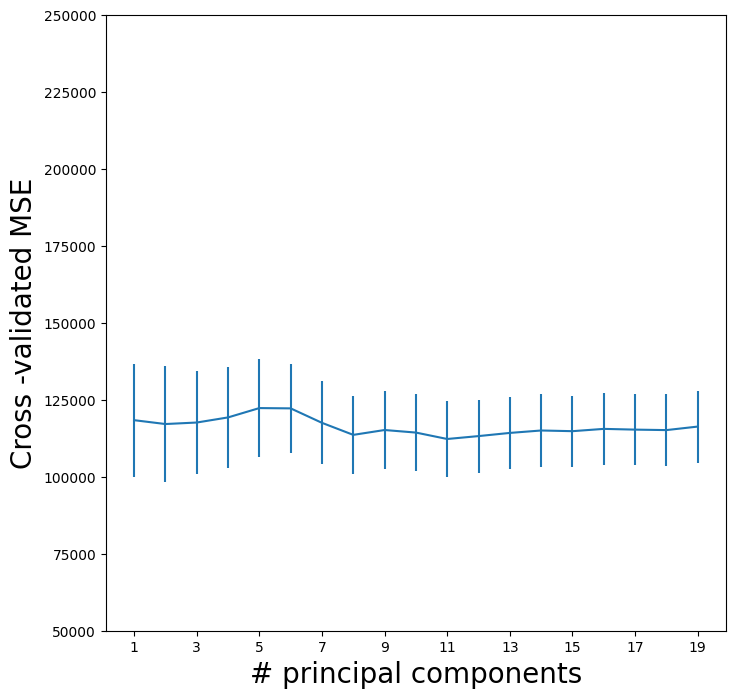

In [ ]:
pls_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp ,
-grid.cv_results_['mean_test_score'],
grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::2])
ax.set_ylim ([50000 ,250000]);